## Assignment 1: Evolutionary process discovery

This assignment is about descovering a PN Matrix from the logged activities of a company, in the dataset_a1.txt

gen	nevals	max                               	avg     
0  	100   	(np.float64(-2.7365762570762575),)	-9.65659
1  	73    	(np.float64(-1.691618353868354),) 	-7.45551
2  	76    	(np.float64(-1.8775772005772007),)	-5.97845
3  	72    	(np.float64(-0.703242923742924),) 	-4.70663
4  	78    	(np.float64(0.36888514263514227),)	-3.59964
5  	78    	(np.float64(0.11204387279387275),)	-2.87406
6  	81    	(np.float64(0.453468947718948),)  	-2.07179
7  	77    	(np.float64(0.453468947718948),)  	-1.61846
8  	65    	(np.float64(0.39523701298701297),)	-1.3    
9  	75    	(np.float64(0.48303174603174603),)	-0.986922
10 	67    	(np.float64(0.4771172438672439),) 	-0.806557
11 	73    	(np.float64(0.4771172438672439),) 	-0.792   
12 	84    	(np.float64(0.4771172438672439),) 	-0.939229
13 	71    	(np.float64(0.5176598124098126),) 	-0.460733
14 	65    	(np.float64(0.5176598124098126),) 	0.0220242
15 	72    	(np.float64(0.5433847541347544),) 	-0.365485
16 	70    	(np.float64(0.606678932178932),)  	-0.237451
17

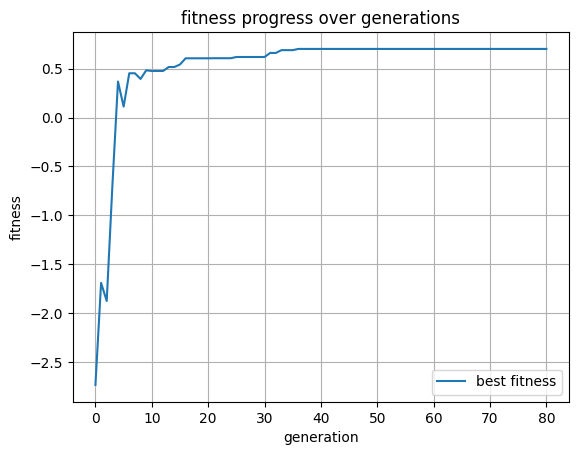

In [1]:
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms
from fitness_module import fitness


# constants
N_VARS = 24
MIN_VAL = 0
MAX_VAL = 8
POP_SIZE = 100
N_GEN = 80
CXPB = 0.6
MUTPB = 0.3

# define deap framework
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, MIN_VAL, MAX_VAL)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, N_VARS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=MIN_VAL, up=MAX_VAL, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# run ga with tracking
pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1)


stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", max)
stats.register("avg", lambda fits: sum(f[0] for f in fits) / len(fits))

pop, logbook = algorithms.eaSimple(
    pop, toolbox,
    cxpb=CXPB, mutpb=MUTPB,
    ngen=N_GEN,
    stats=stats, halloffame=hof,
    verbose=True
)

# plot results
plt.plot(logbook.select("gen"), logbook.select("max"), label="best fitness")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("fitness progress over generations")
plt.grid(True)
plt.legend()
plt.show()

In [2]:
print("Best solution:", hof[0])
print("Best fitness:", hof[0].fitness.values[0])

Best solution: [3, 8, 3, 1, 0, 1, 1, 8, 1, 3, 3, 5, 2, 5, 3, 6, 5, 7, 1, 5, 2, 5, 7, 8]
Best fitness: 0.7026320346320347


In [7]:
def run_ga(crossover, mutation, selection, label):
    toolbox.unregister("mate")
    toolbox.unregister("mutate")
    toolbox.unregister("select")

    toolbox.register("mate", crossover)
    toolbox.register("mutate", mutation, indpb=0.2)
    
    # here if the selection method is tournament, we set the tournsize to 3
    # otherwise we don't pass any arguments to the selection method
    if selection == tools.selTournament:
        toolbox.register("select", selection, tournsize=3)
    else:
        toolbox.register("select", selection)

    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    
    # we measure the fitness values using the fitness function in fitness module 
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    
    # here we register the statistics we want to track which are the max and avg fitness values
    stats.register("max", max)
    stats.register("avg", lambda fits: sum(f[0] for f in fits) / len(fits))

    # time is measured before and after the algorithm execution
    start_time = time.time()
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN, stats=stats, halloffame=hof, verbose=False)
    end_time = time.time()

    # we extract the ABF (average best fitness) value and the time taken for the execution
    abf = max(log.select("avg"))
    duration = end_time - start_time

    print(f"{label} - ABF: {abf:.2f}, Time: {duration:.2f}s")
    return abf, duration, log

In [ ]:
# Crossover operators
crossovers = {
    "cxTwoPoint": tools.cxTwoPoint,
    "cxOrdered": tools.cxOrdered,
}

# Mutation operators
mutations = {
    "mutFlipBit": tools.mutFlipBit,
    "mutShuffleIndexes": tools.mutShuffleIndexes,
}

# Selection operators
selections = {
    "selTournament": tools.selTournament,
    "selRoulette": tools.selRoulette,
}

# mutation probabilities
mutation_probs = [0.2,0.4,0.6,0.8]

# crossover probabilities
crossover_probs = [0.2,0.4,0.6,0.8]


In [8]:
results = []

for cx_name, cx in crossovers.items():
    for mut_name, mut in mutations.items():
        for sel_name, sel in selections.items():
            label = f"{cx_name}, {mut_name}, {sel_name}"
            abf, time_taken, log = run_ga(cx, mut, sel, label)
            results.append({
                "Crossover": cx_name,
                "Mutation": mut_name,
                "Selection": sel_name,
                "ABF": abf,
                "Time (Seconds)": time_taken
            })

df = pd.DataFrame(results)
df_sorted = df.sort_values(by=["ABF", "Time (Seconds)"], ascending=[False, True])
print(df_sorted)

cxTwoPoint, mutFlipBit, selTournament - ABF: -0.45, Time: 142.83s
cxTwoPoint, mutFlipBit, selRoulette - ABF: -0.48, Time: 89.22s
cxTwoPoint, mutShuffleIndexes, selTournament - ABF: -0.37, Time: 110.45s


KeyboardInterrupt: 